**One subject out cross validation**

**This one will be used to evaluate model performance**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [167]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"
!cp "/content/drive/My Drive/HAR Dataset/HAR Mine/Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv" "accelerometer_extracted_featured_data_without_overlapping.csv"

 acc_data_4sec_before_3sec_after.csv
 acc_data_4sec_before_3sec_after_with_magnitude.csv
 accelerometer_extracted_featured_data_without_overlapping.csv
'Additional Testing Code'
'Basic Data'
 checkpoint
 converted_model.tflite
 frozen_har.pb
 history.p
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
 Human_activity_recognition_feature_extract.ipynb
 human_activity_recognition_MINE_2.ipynb
 human_activity_recognition_MINE.ipynb
 predictions.p
'Processed Data'


# Load Library

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sn

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

# Load Data

In [0]:
#columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv')
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv')
#, header = None, names = columns
df = df.dropna()

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 0 to 1260
Data columns (total 33 columns):
mean_x              1261 non-null float64
mean_y              1261 non-null float64
mean_z              1261 non-null float64
magnitude_mean      1261 non-null float64
std_x               1261 non-null float64
std_y               1261 non-null float64
std_z               1261 non-null float64
magnitude_std       1261 non-null float64
rms_x               1261 non-null float64
rms_y               1261 non-null float64
rms_z               1261 non-null float64
magnitude_rms       1261 non-null float64
min_x               1261 non-null float64
min_y               1261 non-null float64
min_z               1261 non-null float64
magnitude_min       1261 non-null float64
max_x               1261 non-null float64
max_y               1261 non-null float64
max_z               1261 non-null float64
magnitude_max       1261 non-null float64
median_x            1261 non-null float64
median_y   

# Data Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

In [171]:
df.head()
#print(df['mean_x'])
#print(df['mean_x'].values[0])


,mean_x,mean_y,mean_z,magnitude_mean,std_x,std_y,std_z,magnitude_std,rms_x,rms_y,rms_z,magnitude_rms,min_x,min_y,min_z,magnitude_min,max_x,max_y,max_z,magnitude_max,median_x,median_y,median_z,magnitude_median,mad_x,mad_y,mad_z,magnitude_mad,corr_xy,corr_yz,corr_xz,subject,class
0,-1.644151,7.299989,-4.774019,9.194468,1.374718,1.303727,1.601727,0.633384,2.143148,7.415493,5.035552,9.216258,-3.890869,4.947205,-7.264801,7.616315,1.022034,10.116287,-0.647232,10.606999,-1.443993,7.268387,-4.960381,9.253738,1.145463,1.075877,1.239351,0.493521,0.803482,0.755901,0.724554,2,SITTING
1,-4.893322,2.375117,-8.347987,10.039573,0.647945,1.077232,0.453523,0.517292,4.936034,2.607989,8.360298,10.052891,-5.834961,0.261749,-9.491409,8.587557,-2.504623,5.095642,-7.202560,11.571552,-4.917984,1.873054,-8.333808,10.034463,0.466141,0.848993,0.334032,0.331420,0.147029,0.330089,0.287061,2,SITTING
2,-4.714092,1.146173,-8.771570,10.045569,0.542208,0.410817,0.462359,0.489795,4.745172,1.217573,8.783748,10.057503,-6.402389,-0.492416,-10.326981,9.372080,-3.649048,2.102890,-7.968704,12.089280,-4.677368,1.134445,-8.762375,9.961059,0.364911,0.280063,0.326969,0.301609,0.287382,0.298514,0.050644,2,SITTING
3,-4.440626,1.069510,-8.864417,9.972461,0.071734,0.047943,0.063884,0.049366,4.441206,1.070584,8.864647,9.972584,-4.570816,0.944107,-8.995804,9.865092,-4.271545,1.226624,-8.758789,10.071942,-4.436752,1.070999,-8.861740,9.964040,0.059195,0.035829,0.051725,0.042919,0.194947,0.208995,-0.454511,2,SITTING
4,-4.375648,0.917478,-8.933562,9.991692,0.120399,0.155448,0.059223,0.069623,4.377304,0.930554,8.933758,9.991934,-4.709686,0.434143,-9.072418,9.695230,-3.852570,1.159576,-8.753998,10.174546,-4.358940,0.938118,-8.938354,10.006441,0.077469,0.110670,0.045394,0.043270,-0.026265,0.537605,-0.009120,2,SITTING


['SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS']


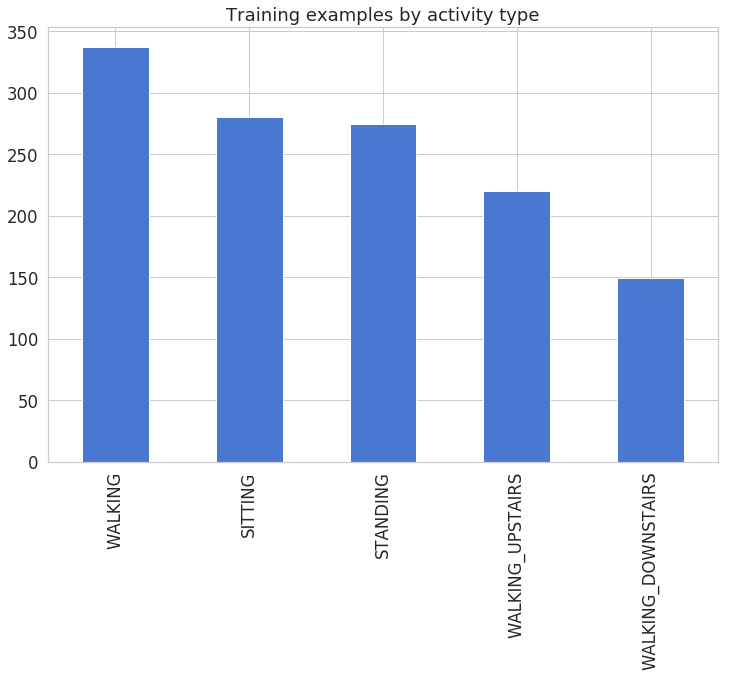

In [172]:
df['class'].value_counts().plot(kind='bar', title='Training examples by activity type');
unique_activities = np.unique(df['class'])
print(unique_activities)

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

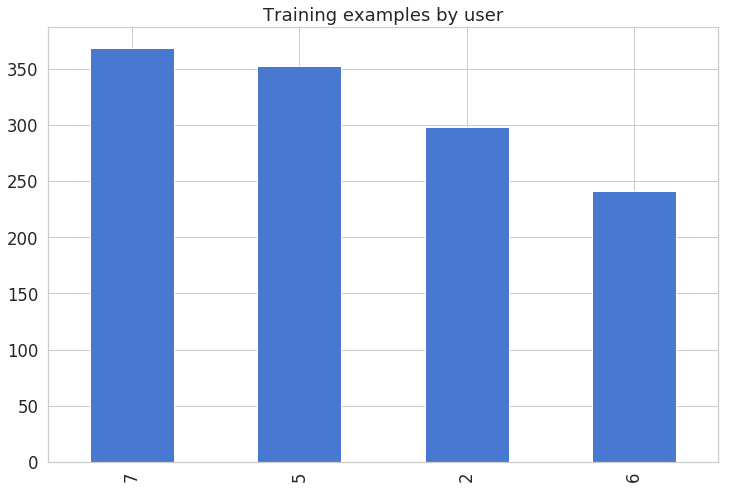

In [173]:
df['subject'].value_counts().plot(kind='bar', title='Training examples by user');

I wonder whether or not number 4 received the same paycheck as number 20. Now, for some accelerometer data:

In [0]:
def plot_activity(subject, activity, df, activity_name):
  
  one_subject_segdata = df.loc[df['subject'] == subject]
  data = one_subject_segdata[one_subject_segdata['class'] == activity][['mean_x', 'mean_y',]][:200]
  axis = data.plot(subplots=True, figsize=(18, 14), 
                   title= 'Subject: '+str(subject) + ' Activity: '+activity_name)
  for ax in axis:
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

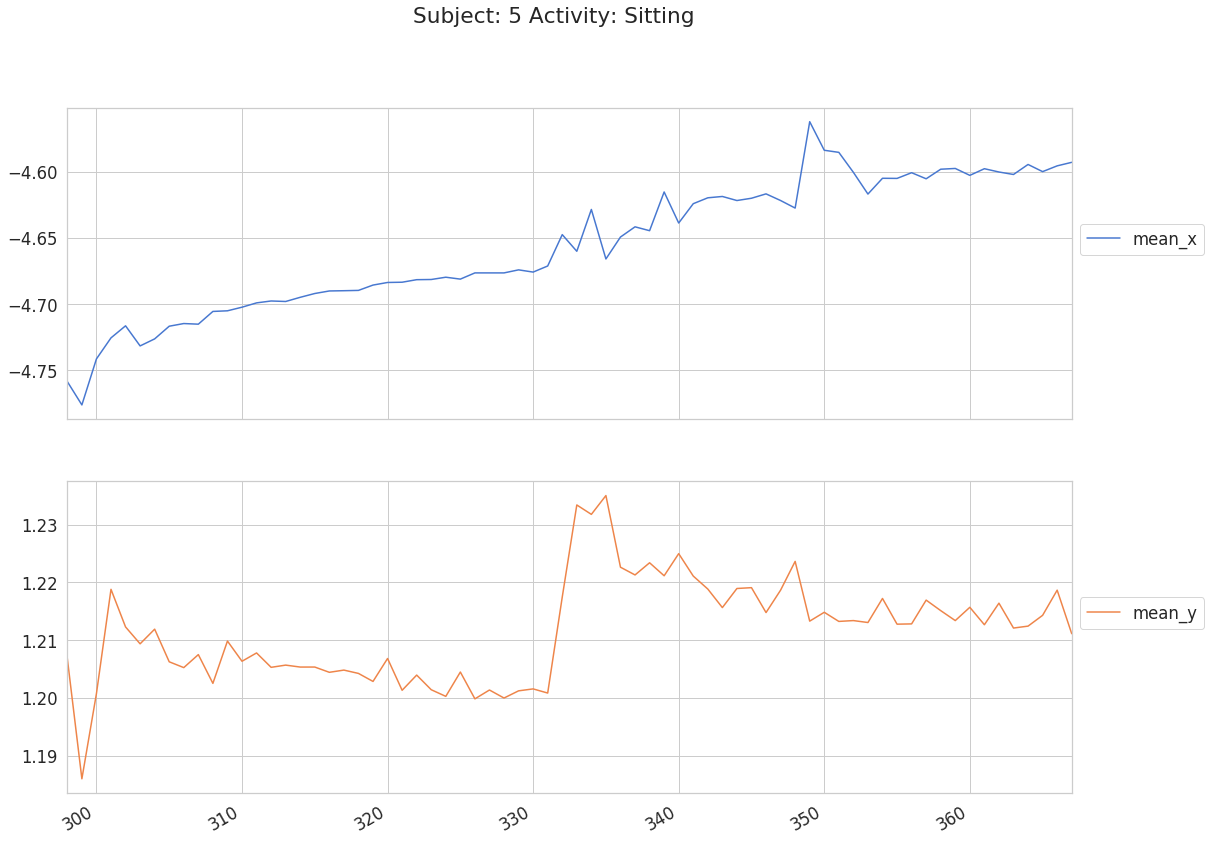

In [175]:
#plot_activity("Sitting", df)
plot_activity(5,"SITTING", df, "Sitting")

# Data Preprocessing

In [176]:
unisubs = np.unique(df['subject'])
print(unisubs,type(unisubs))

#unisubs = np.asarray([2,5,6,7])
#print(unisubs,type(unisubs),type(np.asarray(unisubs)))
#one_subject_segdata = df.loc[df['subject'] == unisubs[i]]

[2 5 6 7] <class 'numpy.ndarray'>


In [177]:
data = df.values
print("Total numbers of row ",len(data), len(df), data.shape)
le = preprocessing.LabelEncoder()
y = le.fit_transform(data[:,-1].astype('str'))+1

subjects = np.unique(df['subject'])
print(subjects)

activity_ids = np.unique(y)
n_class = len(activity_ids)
print(activity_ids)

Total numbers of row  1261 1261 (1261, 33)
[2 5 6 7]
[1 2 3 4 5]


In [0]:
columns = ['mean_x', 'mean_y', 'mean_z', 'magnitude_mean',
            'std_x', 'std_y', 'std_z', 'magnitude_std',
            'rms_x', 'rms_y', 'rms_z', 'magnitude_rms',
            'min_x', 'min_y', 'min_z', 'magnitude_min',
            'max_x', 'max_y', 'max_z', 'magnitude_max',
            'median_x', 'median_y', 'median_z', 'magnitude_median',
            'mad_x', 'mad_y', 'mad_z','magnitude_mad',
           'corr_xy','corr_yz', 'corr_xz',
            'subject',  'class']

N_TIME_STEPS = 10
N_FEATURES = 31
step = 5

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [0]:
N_CLASSES = 5
N_HIDDEN_UNITS = 32

In [0]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)
    
    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    lstm_layers = [tf.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.nn.rnn_cell.MultiRNNCel(lstm_layers)
    outputs, _ = tf.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [0]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:

In [0]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Finally, let's define optimizer and accuracy ops:

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [0]:
def make_sequence(data):
  
  segments = []
  labels = []
  
  for i in range(0, len(data) - N_TIME_STEPS, step):
    sequence_array= []
    for j in range (0, len(columns)-2):
      sequence_array.append(data[columns[j]].values[i: i + N_TIME_STEPS])
    segments.append(sequence_array)
    
    #xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    #ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    #zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(data['class'][i: i + N_TIME_STEPS])[0][0]
    #segments.append([xs, ys, zs])
    labels.append(label)
  
  return segments, labels

In [0]:
def create_train_test_data(train_data, test_data):
  train_segments, train_labels = make_sequence(train_data)
  test_segments, test_labels = make_sequence(test_data)

  #print(len (train_data),np.asarray(train_segments).shape, type(train_labels), np.asarray(train_labels).shape)
  #print(len (test_data),np.asarray(test_segments).shape,type(test_labels), np.asarray(test_labels).shape)



  reshaped_train_segments = np.asarray(train_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
  train_labels = np.asarray(pd.get_dummies(train_labels), dtype = np.float32)

  reshaped_test_segments = np.asarray(test_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
  test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
  #print(reshaped_train_segments.shape, len(train_labels))
  #print(reshaped_test_segments.shape, len(test_labels))

  X_train = reshaped_train_segments
  y_train =  train_labels
  X_test = reshaped_test_segments
  y_test = test_labels
  return X_train, y_train, X_test, y_test
  

In [0]:
def classification_report(cm):

  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos

  precision = true_pos / (true_pos+false_pos)
  recall = true_pos / (true_pos + false_neg)
  
  f1_score = 2/(precision**-1 + recall**-1)
  return precision, recall, f1_score

In [0]:
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

In [0]:
N_EPOCHS = 10
BATCH_SIZE = 16

In [190]:
subjects = np.unique(df['subject'])
print("Subjects ",subjects)

activity_ids = np.unique(y)
n_class = len(activity_ids)
print("Activity id's ",activity_ids)

activity_ids = np.unique(y)-1
print(activity_ids)

print("\n===========================================\n")

#saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []
accuracy_all = []
print("fold # :  precision, recall, f1score, accuracy")


for f, subject in enumerate(subjects[:]):
  train_data = df.loc[df['subject'] != subject]
  test_data = df.loc[df['subject'] == subject]
  print("Subject ",subject , ", Train Data ",len(train_data)," Test data ", len(test_data))
  
  X_train, y_train, X_test, y_test = create_train_test_data(train_data, test_data)
  
  train_count = len(X_train)
  for i in range(1, N_EPOCHS + 1):
      for start, end in zip(range(0, train_count, BATCH_SIZE),
                            range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
          sess.run(optimizer, feed_dict={X: X_train[start:end],
                                         Y: y_train[start:end]})

      _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                              X: X_train, Y: y_train})

      _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                              X: X_test, Y: y_test})

      #history['train_loss'].append(loss_train)
      #history['train_acc'].append(acc_train)
      #history['test_loss'].append(loss_test)
      #history['test_acc'].append(acc_test)

      #print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')

  predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

  print()
  print(f'Fold No (direct form model)  {f+1} : final results: accuracy: {acc_final} loss: {loss_final}')
  
  #print("y_test >> ",type(y_test), y_test.shape, y_test[0])
  #print(y_test)
  test_y = np.argmax(y_test, axis=1)
  #print("test_y >>",type(test_y), test_y.shape, test_y[0])
  #print(test_y)
  pred = activity_ids[np.argmax(predictions, axis=1)]
  #print("pred >> ",type(pred),pred.shape, pred)
  
  #accuracy = accuracy_score(test_y, pred)
  #print("assssssa")
  
  true_all += list(test_y)
  pred_all += list(pred)
  
  precision, recall, f1score, _ = precision_recall_fscore_support(test_y, pred, average='weighted')
  #accuracy = accuracy_score(test_y, pred)
  fold_result += [precision, recall, f1score, acc_final]
  
  accuracy_all += [acc_final] 
  cm_all += confusion_matrix(test_y, pred)
  
  #print("len >> ",len(true_all), " ", len(pred_all))
  print("fold ", f+1,":"," precision, recall, f1score, accuracy ", precision, recall, f1score, acc_final)
  
  '''
  test_y = np.argmax(y_test, axis=1)
  pred = activity_ids[np.argmax(predictions, axis=1)]
  
  true_all += list(test_y)
  pred_all += list(pred)
  
  precision, recall, f1score, _ = precision_recall_fscore_support(test_y, pred, average='weighted')
  accuracy = accuracy_score(test_y, pred)
  fold_result += [precision, recall, f1score, accuracy]
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  
  cm_all += confusion_matrix(test_y, pred)
  '''
  print("\n===========================================\n")

sess.close()

Subjects  [2 5 6 7]
Activity id's  [1 2 3 4 5]
[0 1 2 3 4]


fold # :  precision, recall, f1score, accuracy
Subject  2 , Train Data  963  Test data  298


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '



Fold No (direct form model)  1 : final results: accuracy: 0.8275862336158752 loss: 1.4505995512008667
fold  1 :  precision, recall, f1score, accuracy  0.853448275862069 0.8275862068965517 0.8243378310844578 0.82758623


Subject  5 , Train Data  908  Test data  353

Fold No (direct form model)  2 : final results: accuracy: 0.9275362491607666 loss: 1.1859288215637207
fold  2 :  precision, recall, f1score, accuracy  0.955406911928651 0.927536231884058 0.9333660237550397 0.92753625


Subject  6 , Train Data  1020  Test data  241

Fold No (direct form model)  3 : final results: accuracy: 0.8510638475418091 loss: 1.4928687810897827
fold  3 :  precision, recall, f1score, accuracy  0.7858311900865093 0.851063829787234 0.8153191489361704 0.85106385


Subject  7 , Train Data  892  Test data  369


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Fold No (direct form model)  4 : final results: accuracy: 0.9166666865348816 loss: 1.0722572803497314
fold  4 :  precision, recall, f1score, accuracy  0.9291831357048748 0.9166666666666666 0.9179511584435183 0.9166667




ov_precision, ov_recall, ov_f1score, ov_accuracy
overall: 0.8967495710860435 0.8861788617886179 0.8882488155637333 0.8807133
class-wise precision: [1.         0.96296296 0.89705882 0.57894737 0.90322581]
class-wise recall: [1.         0.96296296 0.91044776 0.73333333 0.7       ]
class-wise f1score: [1.         0.96296296 0.9037037  0.64705882 0.78873239]
class-wise accuracy: [1.         0.96296296 0.91044776 0.73333333 0.7       ]
[[55  0  0  0  0]
 [ 0 52  0  1  1]
 [ 0  0 61  5  1]
 [ 0  1  6 22  1]
 [ 0  1  1 10 28]]


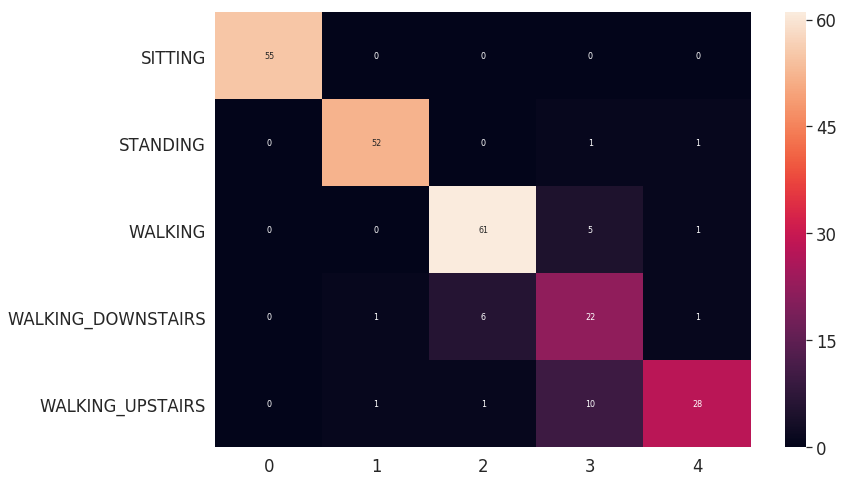

In [191]:

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
#ov_accuracy = accuracy_score(true_all, pred_all)
ov_accuracy = np.mean(accuracy_all)

#print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)
print("ov_precision, ov_recall, ov_f1score, ov_accuracy")
print("overall:", ov_precision, ov_recall, ov_f1score, ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)
  
print(cm_all.astype('int'))

array = confusion_matrix(true_all, pred_all)
#array = confusion_matrix(test_y, pred)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()



# Extra

## train

In [0]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    '''
    if i != 1 and i % 10 != 0:
        continue
    '''
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 1 test accuracy: 0.6206896305084229 loss: 2.0101423263549805
epoch: 2 test accuracy: 0.6379310488700867 loss: 1.8697152137756348
epoch: 3 test accuracy: 0.6379310488700867 loss: 1.6884303092956543
epoch: 4 test accuracy: 0.7068965435028076 loss: 1.5280895233154297
epoch: 5 test accuracy: 0.9137930870056152 loss: 1.3459298610687256
epoch: 6 test accuracy: 0.8103448152542114 loss: 1.4556078910827637
epoch: 7 test accuracy: 0.7931034564971924 loss: 1.4438337087631226
epoch: 8 test accuracy: 0.8620689511299133 loss: 1.3187587261199951
epoch: 9 test accuracy: 0.8620689511299133 loss: 1.3476711511611938
epoch: 10 test accuracy: 0.931034505367279 loss: 1.2105941772460938

final results: accuracy: 0.931034505367279 loss: 1.2105941772460938


In [0]:
print(activity_ids)
activity_ids = np.unique(y)-1
print(activity_ids)

[0 1 2 3 4]
[0 1 2 3 4]


<class 'numpy.ndarray'> (58, 5) [1. 0. 0. 0. 0.]
<class 'numpy.ndarray'> (58,) 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4]
<class 'numpy.ndarray'> (58,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 2 2 2 2 2
 2 1 4 3 3 3 3 3 3 3 2 4 3 4 2 3 2 2 2 2 2]
accuracy  0.7931034482758621
precision, recall, f1score, accuracy
0.7855603448275862 0.7931034482758621 0.7733022889476922 Tensor("Mean_1:0", shape=(), dtype=float32)
class-wise precision: [1.         0.9375     0.5        0.77777778 0.5       ]
class-wise recall: [1.         1.         0.77777778 0.77777778 0.2       ]
class-wise f1score: [1.         0.96774194 0.60869565 0.77777778 0.28571429]
class-wise accuracy: [1.         1.         0.77777778 0.77777778 0.2       ]
[[15  0  0  0  0]
 [ 0 15  0  0  0]
 [ 0  1  7  0  1]
 [ 0  0  1  7  1]
 [ 0  0  6  2  2]]


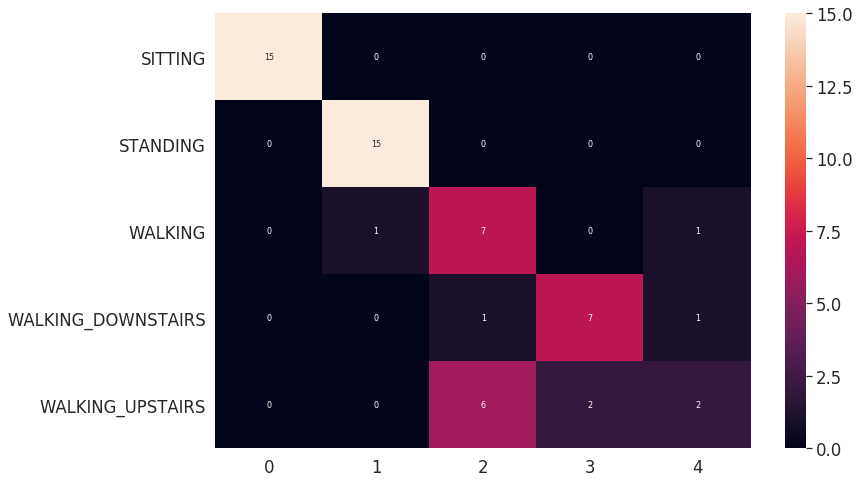

In [0]:
print(type(y_test), y_test.shape, y_test[0])

test_y = np.argmax(y_test, axis=1)
print(type(test_y), test_y.shape, test_y[0])
print(test_y)



#print(predictions)
#print(type(predictions), predictions.shape, predictions[0])
l= np.argmax(predictions, axis=1)
#print (type(l), l.shape, l)
#print (type(l), l.shape)

pred = activity_ids[np.argmax(predictions, axis=1)]
print(type(pred),pred.shape, pred)


acc = accuracy_score(test_y, pred)

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, pred, average='weighted')
print('accuracy ', acc)
print("precision, recall, f1score, accuracy")
print( precision,recall,f1score,accuracy)

cm_all = confusion_matrix(test_y, pred)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))

#array = confusion_matrix(true_all, pred_all)
array = confusion_matrix(test_y, pred)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()


In [0]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))

Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [0]:

#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'checkpoint/har.pbtxt')  
saver.save(sess, save_path = "checkpoint/har.ckpt")


'''
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'har.pbtxt')  
saver.save(sess, save_path = "har.ckpt")
sess.close()


'''

'\npickle.dump(predictions, open("predictions.p", "wb"))\npickle.dump(history, open("history.p", "wb"))\n#tf.train.write_graph(sess.graph_def, \'.\', \'./checkpoint/har.pbtxt\')  \n#saver.save(sess, save_path = "./checkpoint/har.ckpt")\n\ntf.train.write_graph(sess.graph_def, \'.\', \'har.pbtxt\')  \nsaver.save(sess, save_path = "har.ckpt")\nsess.close()\n\n\n'

In [0]:
sess.close()

And loading it back:

In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

## Evaluation

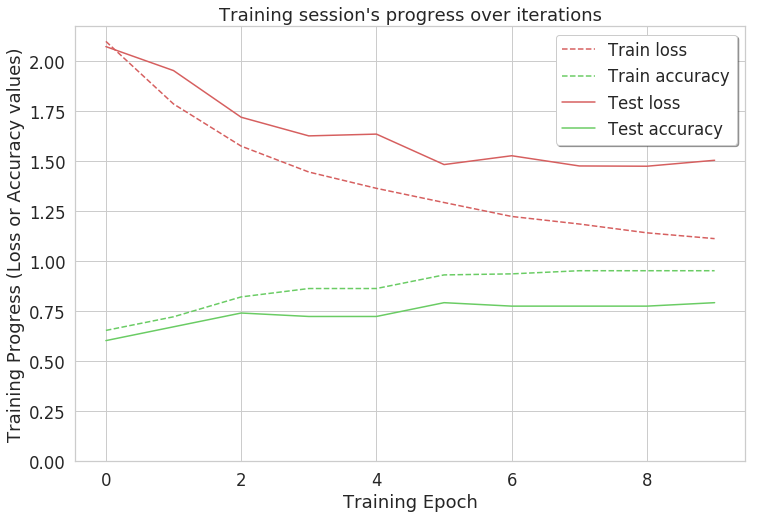

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [0]:
#LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

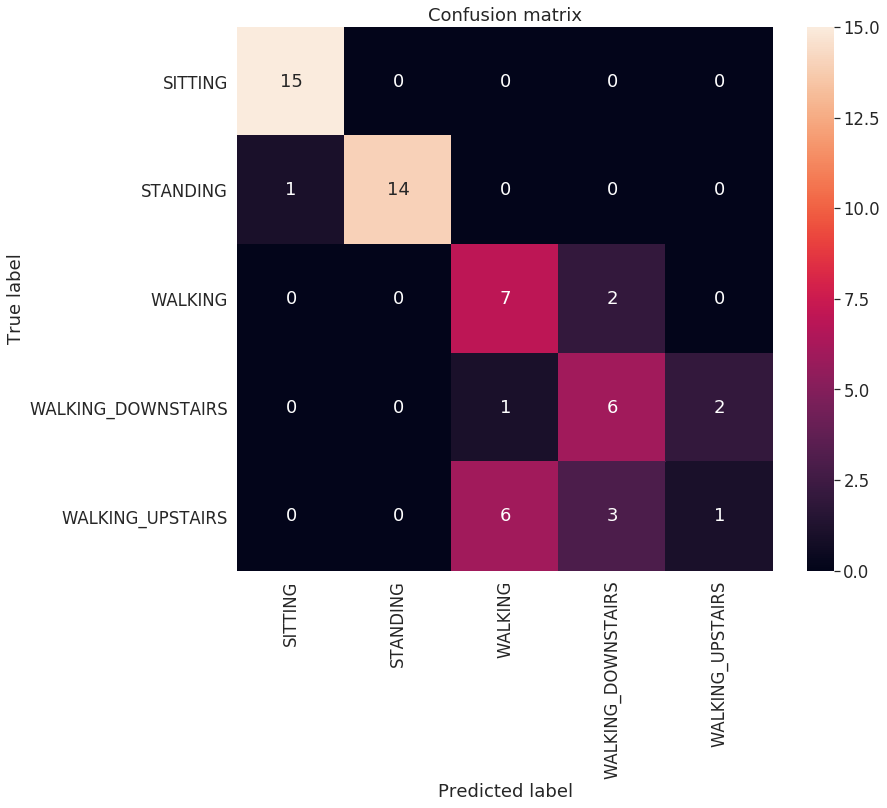

In [0]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [0]:
# tensprflow cpu VERSION 1.13.1
print(tf.__version__)

1.14.0


Again, it looks like our model performs real good. Some notable exceptions include the misclassification of  Upstairs for Downstairs and vice versa. Jogging seems to fail us from time to time as well!

## Exporting the model

Now that most of the hard work is done we must export our model in a way that TensorFlow for Android will understand it:

In [0]:
from tensorflow.python.tools import freeze_graph

#MODEL_NAME = 'har'
MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
#output_frozen_graph_name = 'frozen_model_new2'+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 10
        }
        dim {
          size: 31
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 31
          }
          dim {
            size: 32
          }
        }
        tensor_content: "\335\n\225?\230\325\260\277F\010G\277\223 \000\300\244\213\346>\204\347$\277\2166\220>\026|\021?\224\212(?\316\373\037?\373\330<\277?DH?\327\267{?y*\002\275K\234R?\353\226\020\277\262.\013?\202\221\321\276\203,,\277s\n\025?h\212\201\2766\343\221?6N\251\277\322\235\031?\226C^>SI\343\277aC\226?#\234\221\277\304fw?$1\224\277\320\225(=\244h+?8\rk\

##convert to tflite model

In [0]:
# tensprflow cpu VERSION 1.13.1
# print(tf.__version__)

graph_def_file = 'frozen_'+MODEL_NAME+'.pb'
#graph_def_file = "frozen_model_new2.pb"
input_arrays = ["input"]
output_arrays = ["y_"]

converter = tf.lite.TFLiteConverter.from_frozen_graph(
  graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

127812

In [0]:

# Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(X_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, X_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  #print(result)
  prediction = np.argmax(result)
  #print(prediction, y_test[i],np.argmax(y_test[i]))
  if prediction == np.argmax(y_test[i]):
    correct_case += 1
print (correct_case)
print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(X_test)))

43
TensorFlow Lite Evaluation result is 0.7413793103448276
